In [1]:
from scipy.spatial import Voronoi, voronoi_plot_2d

import alphashape as ap

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["figure.dpi"] = 150

import pandas as pd
from colour import Color
import os

import vis.Visualization as visual
import vis.CommunityWise as cwise

In [2]:
# Now read in the data
locationFile = 'Location_20.csv'
communityFolder = 'communities'
dataFrame = pd.read_csv(locationFile)

# Read in the different communities we have
communityFiles = os.listdir(communityFolder)
communityArr = []
for file in communityFiles:
    if 'csv' in file:
        currComm = np.genfromtxt(f'{communityFolder}/{file}', dtype='int')
        # Make sure that we have a continuous set of integer labels for our communities
        # ie take [1, 4, 7, 3, 2, 6] -> [0, 3, 5, 2, 1, 4]
        currComm = cwise.patchCommunityIndices(currComm)
        # Now make sure we don't have empty communities
        # and that they are the same length as our position data
        # I am not sure why there are entries that aren't the same length...
        if np.sum(currComm) != 0 and len(currComm) == len(dataFrame["x"]):
            communityArr.append(currComm)
        
communityArr = np.array(communityArr)

print(communityArr)

# Generate the voronoi tesselation
points = np.zeros([len(dataFrame["x"]), 2])
points[:,0] = dataFrame["x"]
points[:,1] = dataFrame["y"]

mapVor = Voronoi(points)

[[  0   0   1 ... 111  44 115]
 [  0   0   1 ... 490 506 511]
 [  0   0   1 ... 164 176 179]
 ...
 [  0   0   0 ...   0   0  34]
 [  0   0   1 ... 234 253 254]
 [  0   0   1 ... 567 593 601]]


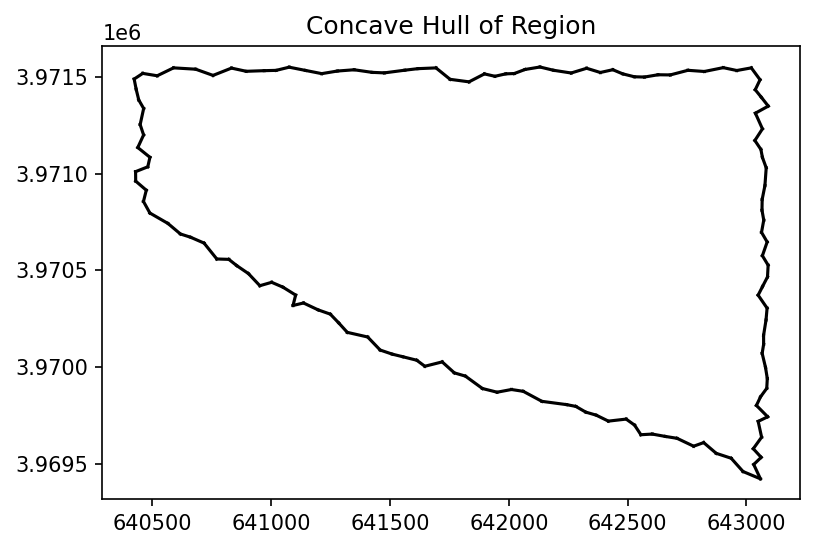

In [3]:
hullLines, hullLineCommunities = cwise.concaveHull(points, communityArr[0])

# And draw the hull
fig, ax = plt.subplots()
visual.drawLines(ax, hullLines)
plt.title("Concave Hull of Region")
plt.show()

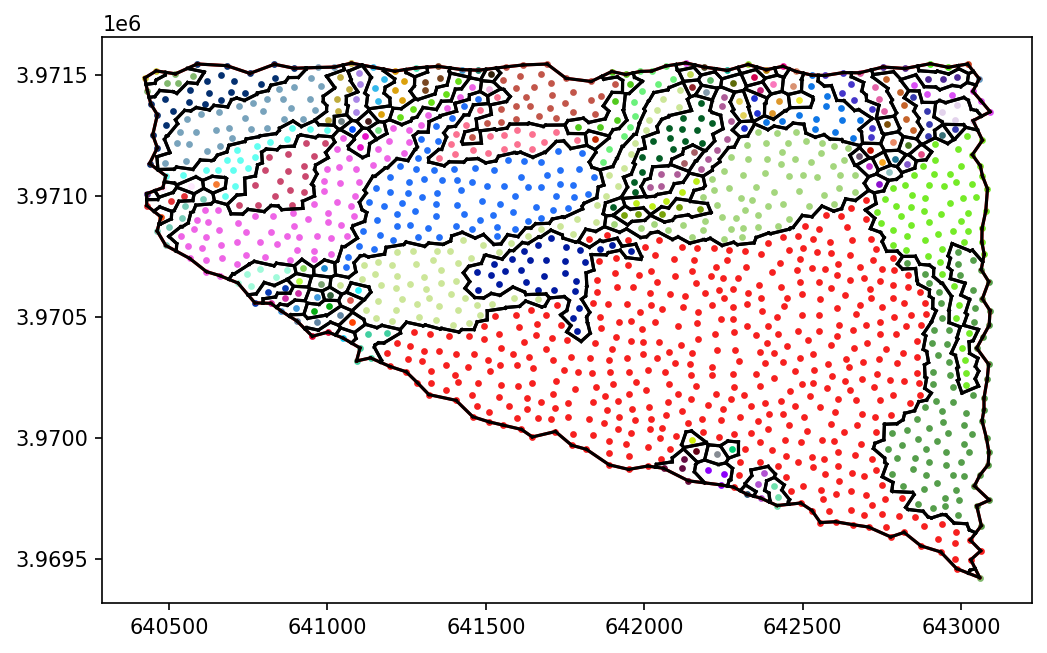

In [9]:
communityBoundaries = cwise.vorToCommunityBounds(mapVor, communityArr[0], hullLines, hullLineCommunities)

# Now show everything
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

randomColors = visual.genRandomColors(max(communityArr[0]))

# Plot the points
visual.drawPoints(ax, points, communityArr[0], randomColors, s=5)

#print(communityBoundaries[15])
#print(hullLines[0:10])
# Draw the boundaries for specific comminities
visual.drawLines(ax, hullLines, 'red')
for i in range(len(communityBoundaries)):
    visual.drawLines(ax, communityBoundaries[i], 'black')

plt.savefig('images/community_boundaries.png')
plt.show()

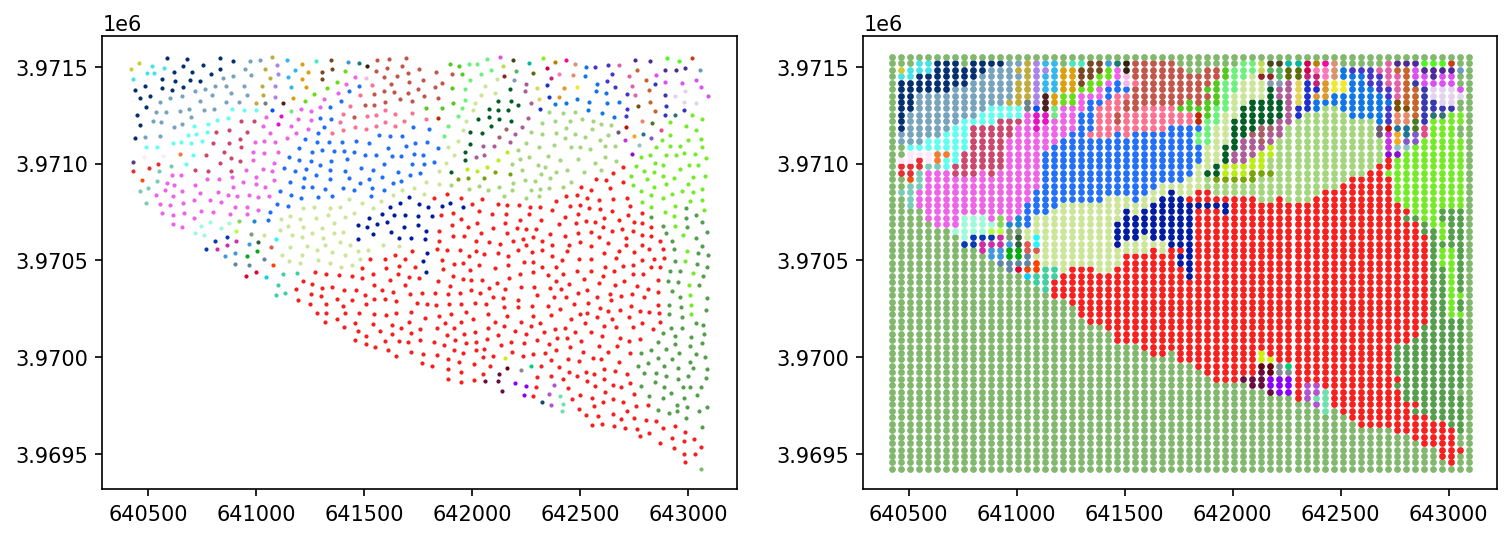

In [7]:
# Now we create a uniform grid and determine which points are in which communities
gridPoints = 65
communities = communityArr[0]
randomColors = visual.genRandomColors(max(communities)+1)

uniformX = np.linspace(min(points[:,0]), max(points[:,0]), gridPoints)
uniformY = np.linspace(min(points[:,1]), max(points[:,1]), gridPoints)

uniformGridPoints = np.zeros([gridPoints, gridPoints, 2])

for i in range(gridPoints):
    for j in range(gridPoints):
        uniformGridPoints[i,j] = [uniformX[i], uniformY[j]]
        
uniformGridPoints = uniformGridPoints.reshape([gridPoints*gridPoints, 2])
internalGridPoints = []

#plt.scatter(uniformGridPoints[:,0], uniformGridPoints[:,1], s=.2)

uniformCommunities = np.zeros(len(uniformGridPoints), dtype=int) - 1

for i in range(len(uniformCommunities)):
    for j in range(max(communities)+1):
        if visual.isInsideHull(uniformGridPoints[i], communityBoundaries[j]):
            uniformCommunities[i] = j
            internalGridPoints.append(uniformGridPoints[i])
        
        
#print(np.shape(uniformGridPoints))
#print(np.shape(points))
#print(uniformCommunities)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot the points
visual.drawPoints(ax[0], points, communities, randomColors, s=5)
visual.drawPoints(ax[1], uniformGridPoints, uniformCommunities, randomColors, s=5)

plt.savefig('images/continuum_transform.png')
plt.show()

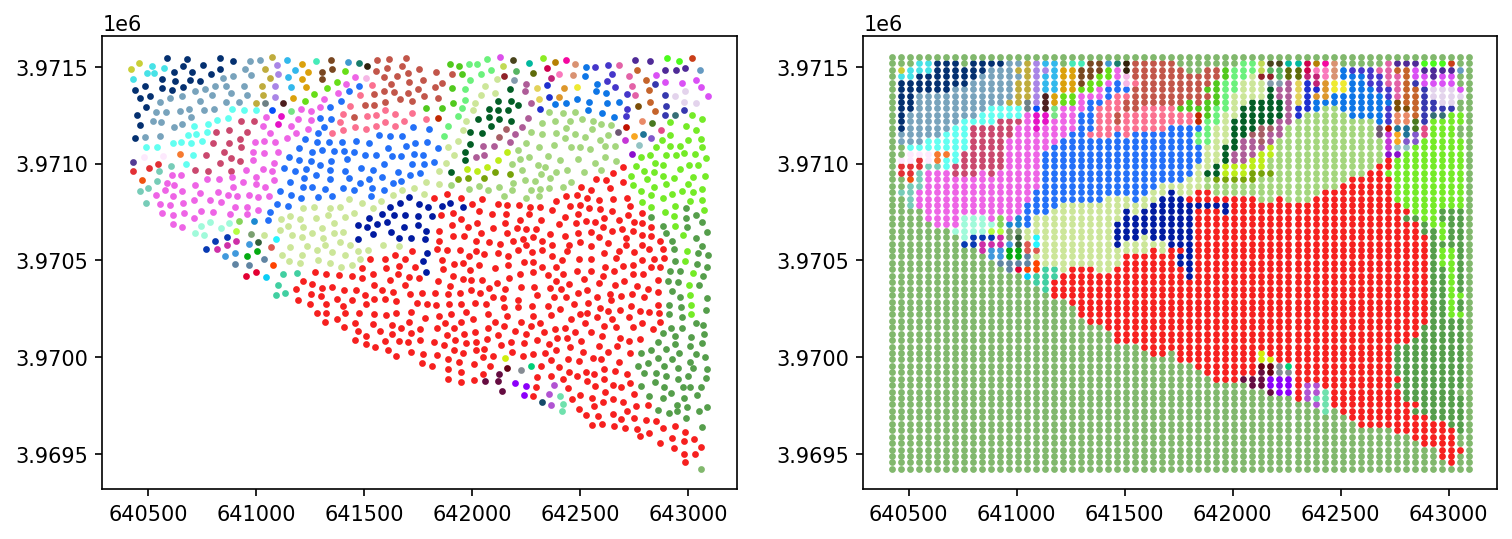

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot the points
visual.drawPoints(ax[0], points, communities, randomColors, s=5)
visual.drawPoints(ax[1], uniformGridPoints, uniformCommunities, randomColors, s=5)

plt.savefig('images/continuum_transform.png')
plt.show()